# Investigate outliers in WST/WCT comparisons with in situ

Read the satellite data from the MDB files, using the ``s3analysis`` helper functions which avoid explicitely looping over files (read_satellite_data)

In [29]:
from s3analysis.slstr.mdb.slstrmdb import SLSTRMDB
import datetime
import numpy

# define match-up configuration
mdb = SLSTRMDB(config={
    'mdb_output_root': "/home/cercache/project/s3vt/",
    'reference': 'S3A_SL_2_WCT'
})

start = datetime.datetime(2016, 11, 20)
end = datetime.datetime(2016, 11, 30)

# define match-ups fields to read and use later
slstr_fields = {
    'S3A_SL_2_WST': ['sea_surface_temperature',
                     'quality_level',
                     'time',
                     'lat',
                     'lon',
                     'origin',
                     'dynamic_target_center_index'
            ],
    'S3A_SL_2_WCT': ['cloud_in'],
    'S3A_SL_1_RBT_IR': []
}

felyx_fields = ['lat', 'lon']

# define source of in situ data
source = 'cmems_drifter'

# perform the satellite (WST/WCT) data selection with the s3analysis helper functions
# by default, takes the closest pixel to insitu measurement (most of the time = the center pixel of the box)
res_slstr = mdb.read_satellite_data(source, start,
                              dataset_fields=slstr_fields,
                              felyx_fields=felyx_fields,
                              end=end)

print "Nb match-ups ", len(res_slstr['S3A_SL_2_WST']['time'])

Reading file 44 over 44
Nb match-ups  22380


Read the in situ data using the corresponding function in s3mdbreader package (read_insitu_data)

In [30]:
# Read in situ data
insitu_fields = ['water_temperature', 'solar_zenith_angle',
                 'quality_level']
res_insitu = mdb.read_insitu_data(source, start, insitu_fields, end=end)


File: /home/cercache/project/s3vt/2016/325/S3A_SL_2_WCT_cmems_drifter_20161120180000_20161121000000.nc
File: /home/cercache/project/s3vt/2016/325/S3A_SL_2_WCT_cmems_drifter_20161120120000_20161120180000.nc
File: /home/cercache/project/s3vt/2016/325/S3A_SL_2_WCT_cmems_drifter_20161120060000_20161120120000.nc
File: /home/cercache/project/s3vt/2016/325/S3A_SL_2_WCT_cmems_drifter_20161120000000_20161120060000.nc
File: /home/cercache/project/s3vt/2016/326/S3A_SL_2_WCT_cmems_drifter_20161121180000_20161122000000.nc
File: /home/cercache/project/s3vt/2016/326/S3A_SL_2_WCT_cmems_drifter_20161121120000_20161121180000.nc
File: /home/cercache/project/s3vt/2016/326/S3A_SL_2_WCT_cmems_drifter_20161121060000_20161121120000.nc
File: /home/cercache/project/s3vt/2016/326/S3A_SL_2_WCT_cmems_drifter_20161121000000_20161121060000.nc
File: /home/cercache/project/s3vt/2016/327/S3A_SL_2_WCT_cmems_drifter_20161122180000_20161123000000.nc
File: /home/cercache/project/s3vt/2016/327/S3A_SL_2_WCT_cmems_drifter_201

In [31]:
# prune matchups where no WST values (probably a missing WST file corresponding to the WCT file)
valid_wst_matchups = ~res_slstr['S3A_SL_2_WST']['time'].mask
mdb.reduce(res_insitu, res_slstr, valid_wst_matchups)

print "Nb match-ups ", len(res_slstr['S3A_SL_2_WST']['time'])

Nb match-ups  18349


In [32]:
# calculate WCT cloud mask, using the s3analysis helper function (use the recommended flag combination)
from s3analysis.slstr.cloud import cloud_mask, cloud_summary

cloudy = cloud_mask(res_slstr['S3A_SL_2_WCT']['cloud_in'])

nbcloudy = numpy.count_nonzero(cloudy)
nbmatchups = cloudy.size
print "Number of cloudy pixels : %d (%d percent)" % (nbcloudy, nbcloudy * 100 / nbmatchups)
print "Number of clear sky pixels : %d" % (nbmatchups - nbcloudy)

# reduce to non cloudy match-ups
mdb.reduce(res_insitu, res_slstr, ~cloudy)

print "Nb match-ups ", len(res_slstr['S3A_SL_2_WST']['time'])

Number of cloudy pixels : 15045 (81 percent)
Number of clear sky pixels : 3304
Nb match-ups  3304


In [33]:
# read box data for a few parameters and apply the same selections as above to remove the same invalid match-ups
box_fields = {
    'S3A_SL_2_WST': ['sea_surface_temperature', 'quality_level'],
    'S3A_SL_2_WCT': ['cloud_in', 'confidence_in'],
    'S3A_SL_1_RBT_IR': []
}
resbox = mdb.read_satellite_data(source, start, dataset_fields=box_fields, end=end, full_box=True)
mdb.reduce({}, resbox, valid_wst_matchups)


Reading file 44 over 44


In [34]:
print resbox['S3A_SL_2_WST']['quality_level'].shape

(18349, 21, 21)


In [35]:
mdb.reduce({}, resbox, ~cloudy)
print resbox['S3A_SL_2_WST']['quality_level'].shape

(3304, 21, 21)


## interactive display

First define a plot function for miniprod display of SST and cloud mask

In [36]:
from matplotlib import pyplot 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mask(choice):
    f, axarr = pyplot.subplots(nrows=1, ncols=5, figsize=(15, 7))

    im0 = axarr[0].imshow(resbox['S3A_SL_2_WST']['sea_surface_temperature'][choice, :, :], interpolation='nearest')
    divider0 = make_axes_locatable(axarr[0])
    cax0 = divider0.append_axes("right", size="20%", pad=0.05)
    axarr[0].set_title('SST')
    pyplot.colorbar(im0, cax=cax0)

    im1 = axarr[1].imshow(resbox['S3A_SL_2_WST']['quality_level'][choice, :, :], interpolation='nearest', vmin=0, vmax=5)
    divider1 = make_axes_locatable(axarr[1])
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    axarr[1].set_title('Quality level')
    pyplot.colorbar(im1, cax=cax1)

    im2 = axarr[2].imshow(cloud_mask(resbox['S3A_SL_2_WCT']['cloud_in'][choice, :, :]), interpolation='nearest', vmin=0, vmax=1)
    axarr[2].set_title('Cloud mask')
    divider2 = make_axes_locatable(axarr[2])
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    pyplot.colorbar(im2, cax=cax2)

    im3 = axarr[3].imshow(resbox['S3A_SL_2_WCT']['cloud_in'][choice, :, :], interpolation='nearest')
    divider3 = make_axes_locatable(axarr[3])
    print "cloud_in min/max : ", resbox['S3A_SL_2_WCT']['cloud_in'][choice, :, :].min(), \
        resbox['S3A_SL_2_WCT']['cloud_in'][choice, :, :].max()
    cax3 = divider3.append_axes("right", size="20%", pad=0.05)
    axarr[3].set_title('Cloud flags')
    pyplot.colorbar(im3, cax=cax3)

    im4 = axarr[4].imshow(resbox['S3A_SL_2_WCT']['confidence_in'][choice, :, :], interpolation='nearest')
    divider4 = make_axes_locatable(axarr[4])
    cax4 = divider4.append_axes("right", size="20%", pad=0.05)
    axarr[4].set_title('Summary flag')
    pyplot.colorbar(im4, cax=cax4)
    
    pyplot.show()
    
    # show all individual cloud masks
    all_cloudbox = cloud_summary(resbox['S3A_SL_2_WCT']['cloud_in'][choice, :, :])
    
    print "Used mask flags : ", all_cloudbox.keys()
    nbmasks =  len(all_cloudbox.keys())
    f, axarr = pyplot.subplots(nrows=nbmasks / 4 + 1, ncols=4, figsize=(15, 7))
    for _, flag in enumerate(all_cloudbox.keys()):
        lin = _ / 4
        col = _ % 4
        im0 = axarr[lin, col].imshow(all_cloudbox[flag], interpolation='nearest', vmin=0, vmax=1)
        axarr[lin, col].set_title(flag)
    pyplot.show()

In [37]:
# use additional coherence filters on brightness temperature (S8 and S9) to remove outliers
# we apply this filter only on a 3x3 box around the pixel matching the in situ measurement

# read the 3x3 BTs for S8 and S9
bt_fields = {
    'S3A_SL_2_WCT': [],
    'S3A_SL_2_WST': [],
    'S3A_SL_1_RBT_IR': ['S8_BT_in', 'S9_BT_in']
}
l1_subboxres = mdb.read_satellite_data(
    source, start, 
    dataset_fields=bt_fields,
    end=end,
    full_box=True,
    subbox=3
    )

# prune macth-ups which don't have any WST info or cloudy
mdb.reduce({}, l1_subboxres, valid_wst_matchups)
mdb.reduce({}, l1_subboxres, ~cloudy)
print l1_subboxres['S3A_SL_1_RBT_IR']['S8_BT_in'].shape


Reading file 44 over 44
(3304, 3, 3)


In [38]:
slstr_sst = res_slstr['S3A_SL_2_WST']['sea_surface_temperature']
insitu_sst = res_insitu['water_temperature'] + 273.15

print l1_subboxres['S3A_SL_1_RBT_IR']['S8_BT_in'].shape

# coherence test on brightness temperature
threshold = 0.05
coherent = ~((l1_subboxres['S3A_SL_1_RBT_IR']['S8_BT_in'][:].std(axis=(1,2)) > threshold) |
             (l1_subboxres['S3A_SL_1_RBT_IR']['S9_BT_in'][:].std(axis=(1,2)) > threshold))
filledbox = (l1_subboxres['S3A_SL_1_RBT_IR']['S8_BT_in'][:].count(axis=(1,2)) == 9)

# additional filter to keep only nighttime data
night = (res_insitu['solar_zenith_angle'] > 90.) & (~slstr_sst.mask & ~insitu_sst.mask) & coherent & filledbox


(3304, 3, 3)


In [39]:
# achtung! plotly neeeds to be installed in your environment (pip install plotly)

import plotly.graph_objs as go
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# allow inline plot with plotly
init_notebook_mode(connected=True)

# Create a interactive scatterplot SST vs in situ with plotly
trace = go.Scattergl(
    x = insitu_sst[night],
    y = slstr_sst[night],
    text = numpy.arange(len(slstr_sst))[night],
    mode = 'markers',
    marker = dict(
        color = 'FFBAD2',
        line = dict(width = 1)
    )
)
data = [trace]
iplot(data)

print len(insitu_sst[night]), ' night match-ups'

460  night match-ups


# Investigate a match-up

SST value : 282.639984 K
In situ value : 295.770001 K
SST - in situ difference : -13.130017 K
Traceability:
....WST file :  S3A_SL_2_WST____20161121T051430_20161121T051730_20161121T065004_0179_011_147______MAR_O_NR_002.SEN3
cloud_in min/max :  0 1088


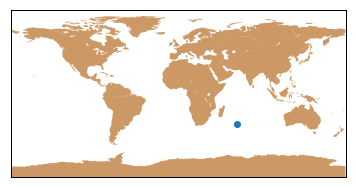

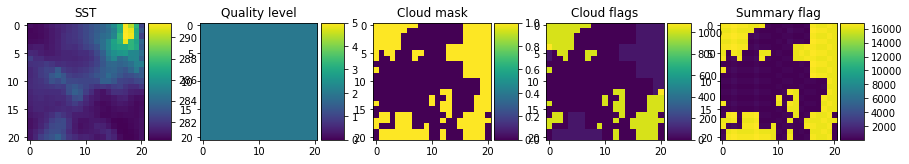

Used mask flags :  ['visible', '1.37_threshold', '1.6_small_histogram', '1.6_large_histogram', '2.25_small_histogram', '2.25_large_histogram', '11_spatial_coherence', 'gross_cloud', 'thin_cirrus', 'medium_high', 'fog_low_stratus', '11_12_view_difference', '3.7_11_view_difference', 'thermal_histogram', 'spare']


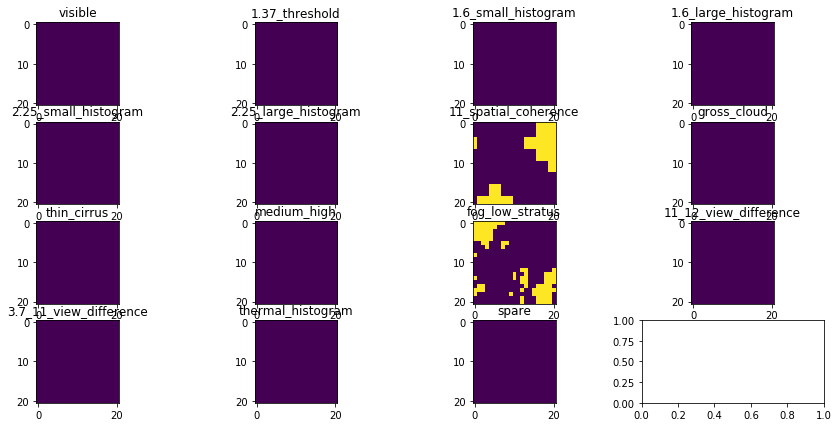

In [40]:
choice = 577

   
# display match-up info
print "SST value : %f K" % slstr_sst[choice]
print "In situ value : %f K" % insitu_sst[choice]
print "SST - in situ difference : %f K" % (slstr_sst[choice] - insitu_sst[choice])

print "Traceability:"
print "....WST file : ", res_slstr['S3A_SL_2_WST']['origin'][choice]

# locate match-up on map
from mpl_toolkits.basemap import Basemap
m = Basemap()
m.drawmapboundary()
m.fillcontinents(color='#cc9966')
x, y = m(res_slstr['S3A_SL_2_WST']['lon'][choice], res_slstr['S3A_SL_2_WST']['lat'][choice])
m.scatter(x, y)


# plot cloud and SST
plot_mask(choice)

## trace back to original file

Here we access the content of the original file from which the match-up was extracted, and display a larger area around the match-up location.

**This require to have access to the original SLSTR files!**

In [41]:
# read indices (offsets in original file) of the selected match-up
print res_slstr['S3A_SL_2_WST']['dynamic_target_center_index'][choice]

[437 272]


/home/cerdata/provider/eumetsat/satellite/l2/sentinel-3/slstr/s3a_sl_2_wst___nr/2016/326/S3A_SL_2_WST____20161121T051430_20161121T051730_20161121T065004_0179_011_147______MAR_O_NR_002.SEN3


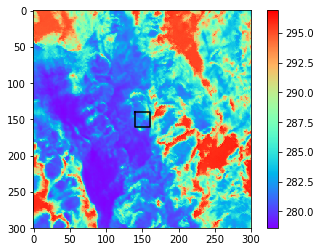

In [42]:
import os, datetime

fname = res_slstr['S3A_SL_2_WST']['origin'][choice]
ftime = datetime.datetime.strptime(fname[16:24], "%Y%m%d")

# get full path name
fullpathname = os.path.join(
    '/home/cerdata/provider/eumetsat/satellite/l2/sentinel-3/slstr/s3a_sl_2_wst___nr/',
    ftime.strftime("%Y/%j/"),
    fname
)
print fullpathname


# define large subset
row, cell = res_slstr['S3A_SL_2_WST']['dynamic_target_center_index'][choice]
boxwidth = 300
boxheight = 300
larger_box = {'row': slice(max(0, row - boxheight / 2), row + boxheight / 2),
              'cell': slice(max(0, cell - boxwidth / 2), cell + boxheight / 2)
             }

# load data into a cerbere swa=th object
from cerbere.mapper.safeslfile import SAFESLWSTFile
from cerbere.datamodel.swath import Swath
wstfile = SAFESLWSTFile(fullpathname)
swath = Swath()
swath.load(wstfile)

# extract the subset
data = swath.get_values('sea_surface_temperature', slices=larger_box)

# display
from matplotlib import pyplot
bottom = row - max(0, row - boxheight / 2) - 10
top = row - max(0, row - boxheight / 2) + 10
left = cell - max(0, cell - boxheight / 2) - 10
right = cell - max(0, cell - boxheight / 2) + 10
pyplot.plot([bottom, bottom, top, top, bottom], [left, right, right, left, left], color='k')
pyplot.imshow(data, cmap='rainbow')

pyplot.colorbar()
pyplot.show()